In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn

# Load dataframes
awards_players = pd.read_csv('../data/awards_players.csv')
coaches = pd.read_csv('../data/coaches.csv')
players_teams = pd.read_csv('../data/players_teams.csv')
players = pd.read_csv('../data/players.csv')
series_post = pd.read_csv('../data/series_post.csv')
teams_post = pd.read_csv('../data/teams_post.csv')
teams = pd.read_csv('../data/teams.csv')

teamsYY = pd.read_csv('../data/seasonYY/teams.csv')
players_teamsYY = pd.read_csv('../data/seasonYY/players_teams.csv')
coachesYY = pd.read_csv('../data/seasonYY/coaches.csv') 

## Merging Dataset with Competition Data


In [2]:
df_YY = [teamsYY, players_teamsYY, coachesYY]
df_1_10 = [teams, players_teams, coaches]

for idx in range(len(df_YY)):
    # Performing a left join on common columns
    merged_df = pd.merge(df_YY[idx], df_1_10[idx], on=list(df_YY[idx].columns), how='left')

    # Finding columns present in df2 but not in df1
    additional_cols = [col for col in df_1_10[idx].columns if col not in df_YY[idx].columns]

    # Filling missing values in the merged dataframe for additional columns with zeros
    merged_df[additional_cols] = merged_df[additional_cols].fillna(-1) #if replace with 0 the wasPresent won't get set properly

    df_1_10[idx] = pd.concat([df_1_10[idx], merged_df], ignore_index=True)

teams = df_1_10[0]
players_teams = df_1_10[1]
coaches = df_1_10[2]

## Cleaning Award Players

In [3]:

# Drop lgID column since all values are 'WNBA'
awards_players.drop('lgID', axis=1, inplace=True)

#Add the missing "award" value for line 30
awards_players.at[28, 'award'] = "Kim Perrot Sportsmanship Award" 
awards_players.head(10)

,playerID,award,year
0,thompti01w,All-Star Game Most Valuable Player,1
1,leslili01w,All-Star Game Most Valuable Player,2
2,leslili01w,All-Star Game Most Valuable Player,3
3,teaslni01w,All-Star Game Most Valuable Player,4
4,swoopsh01w,All-Star Game Most Valuable Player,6
5,douglka01w,All-Star Game Most Valuable Player,7
6,fordch01w,All-Star Game Most Valuable Player,8
7,cashsw01w,All-Star Game Most Valuable Player,10
8,coopemi01w,Coach of the Year,1
9,hugheda99w,Coach of the Year,2


In [3]:
## Cleaning irrelevant data

In [4]:
# We can drop 'lgID', since all values are 'WNBA'
teams_post.drop('lgID', axis=1, inplace=True)

In [5]:
# We can drop 'lgIDWinner and 'lgIDLoser', since all values are 'WNBA'
series_post.drop(['lgIDWinner', 'lgIDLoser'], axis=1, inplace=True)

In [6]:
# We can drop 'lgID', since all values are 'WNBA'
players_teams.drop('lgID', axis=1, inplace=True)
teams_post.drop('lgID', axis=1, inplace=True)
series_post.drop(['lgIDWinner', 'lgIDLoser'], axis=1, inplace=True)
coaches.drop('lgID', axis=1, inplace=True)

# drop stint_coach
coaches.drop('stint', axis=1, inplace=True)

In [5]:
# We can drop 'firstseason', since all values are '0'
players.drop('firstseason', axis=1, inplace=True)
# We can drop 'lastseason', since all values are '0'
players.drop('lastseason', axis=1, inplace=True)

# We can drop 'collegeOther' since it has a lot of missing values
players.drop('collegeOther', axis=1, inplace=True)

# We can drop 'deathDate' since it is not useful
players.drop('deathDate', axis=1, inplace=True)

# Fill nan values in 'college' with 'none'
players['college'].fillna('none', inplace=True)


# Rename the column 'bioID' to 'playerID' to match the other dataframes
players.rename(columns={'bioID': 'playerID'}, inplace=True)

for index, row in players.iterrows():
    # Check if the player is a coach and has never played
    if row['playerID'] in coaches['coachID'].values and pd.isna(row['pos']):
        # Remove the player from the DataFrame
    # if playerID is in coaches, remove it
    if row['playerID'] in coaches['coachID'].values and pd.isna(row['pos']):
        players.drop(index, inplace=True)

In [8]:
# Filter players with height < 60 inches
players = players[players['height'] >= 60]

In [9]:
# We can drop 'lgID', since all values are 'WNBA'
teams.drop('lgID', axis=1, inplace=True)
# We can drop 'franchID', since values are the same as 'teamID'
teams.drop('franchID', axis=1, inplace=True)
# We can drop 'divID', since all values are null
teams.drop('divID', axis=1, inplace=True)
# We can drop 'seeded', since all values are 0
teams.drop('seeded', axis=1, inplace=True)
# We don't believe that the 'name' attribute is relevant, so we drop it
teams.drop('name', axis=1, inplace=True)
# All of these attributes are always 0, se we can simply drop them
teams.drop(['tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB'], axis=1, inplace=True)
# We don't believe that the 'attend' attribute is relevant, so we drop it
teams.drop('attend', axis=1, inplace=True)
# We don't believe that the 'arena' attribute is relevant, so we drop it
teams.drop('arena', axis=1, inplace=True)

In [7]:
# Filter players with no games played
players_teams = players_teams[players_teams['minutes'] > 0]

### Feature Extraction

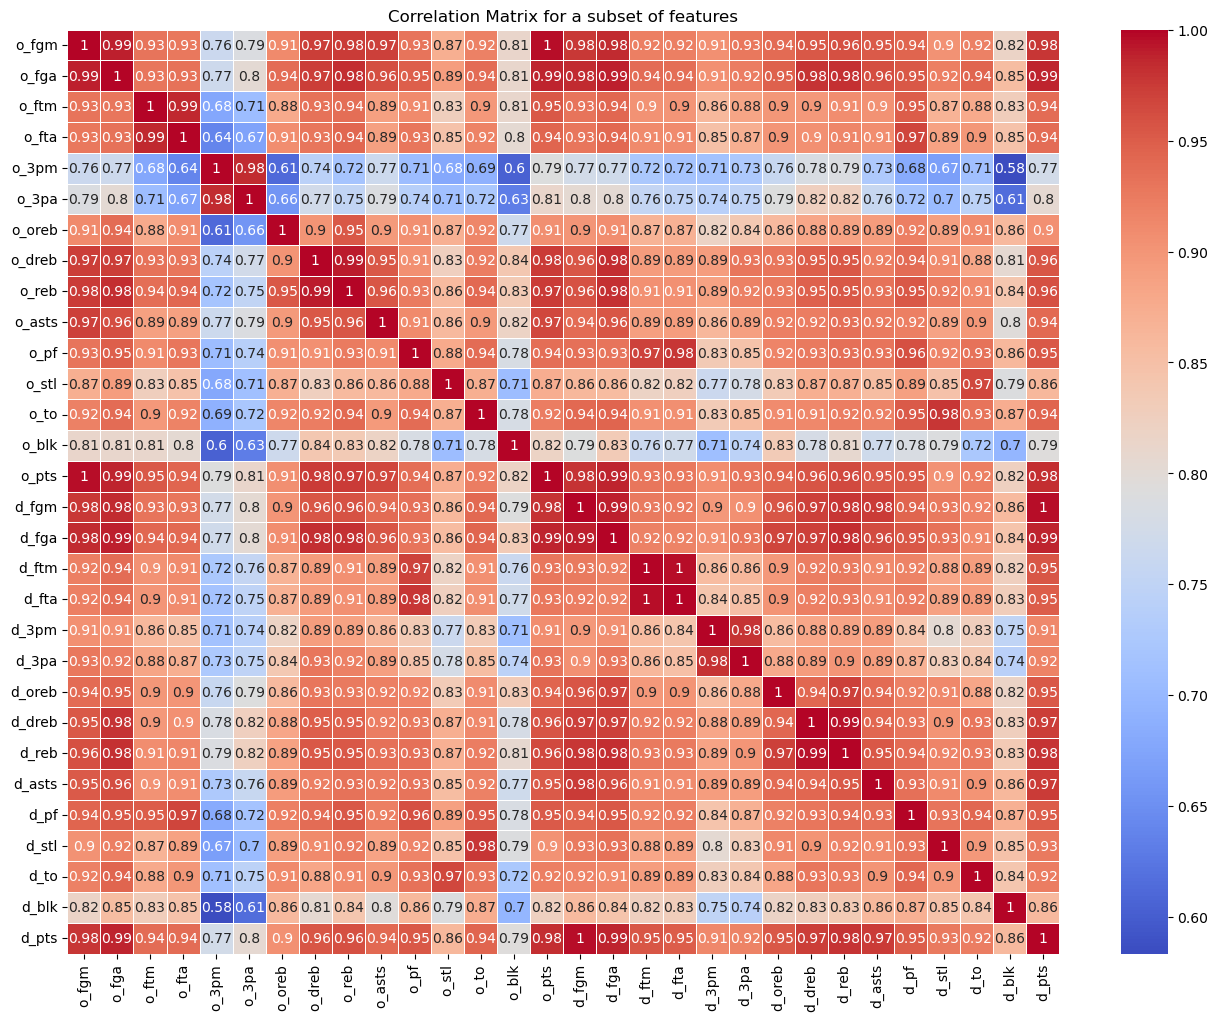

In [11]:
# Select a subset of features
features = ['o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa',
       'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk',
       'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb',
       'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts']

# Calculate the correlation matrix for the subset of features
corr_matrix = teams[features].corr()

# Create a heatmap to visualize the correlation matrix for the subset of features
plt.figure(figsize=(16, 12))
sbn.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix for a subset of features')
plt.show()

In [9]:
# Drop the columns that are highly correlated
teams.drop(['o_ftm','o_3pm','o_fgm','d_ftm','d_3pm','d_fgm'], axis=1, inplace=True)
teams.drop(['o_oreb', 'o_dreb', 'd_oreb', 'd_dreb'], axis=1, inplace=True)

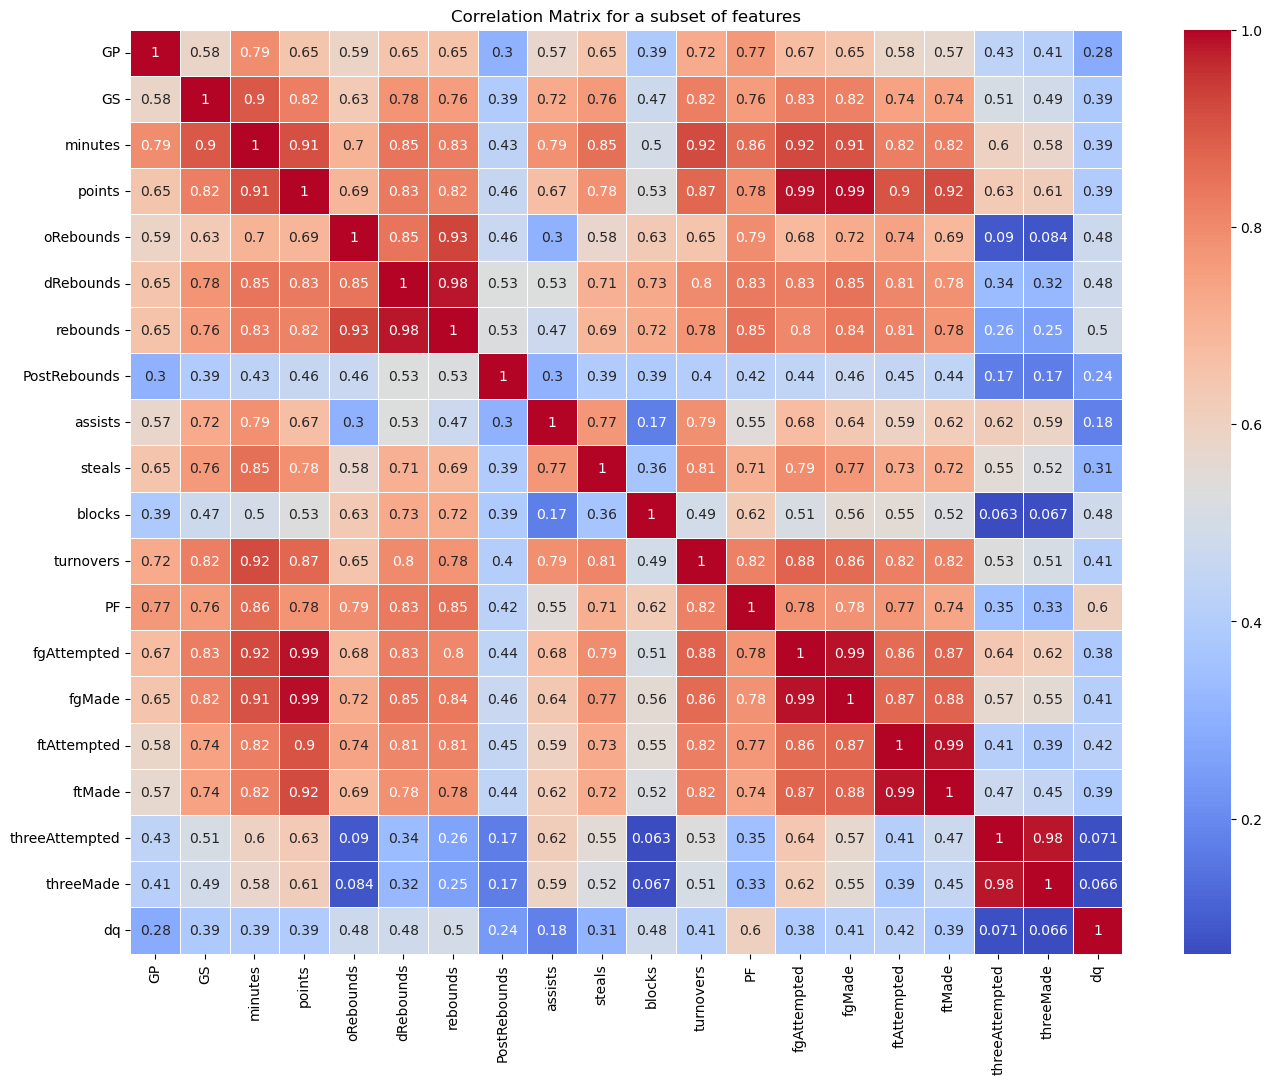

In [10]:
# Select a subset of features
features = ['GP', 'GS', 'minutes',
       'points', 'oRebounds', 'dRebounds', 'rebounds', 'PostRebounds', 'assists', 'steals',
       'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted',
       'ftMade', 'threeAttempted', 'threeMade', 'dq']

# Calculate the correlation matrix for the subset of features
corr_matrix = players_teams[features].corr()

# Create a heatmap to visualize the correlation matrix for the subset of features
plt.figure(figsize=(16, 12))
sbn.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix for a subset of features')
plt.show()

In [14]:
# Drop the columns that are highly correlated
players_teams.drop(['dRebounds'], axis=1, inplace=True)

C:\Users\utilizador\AppData\Local\Temp\ipykernel_19444\296200413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_teams.drop(['dRebounds'], axis=1, inplace=True)


In [15]:
## Awards

,playerID,year,award_points,last_3_years_sum,all_time_sum
0,arcaija01w,1,0.0,0,0
1,arcaija01w,2,6.0,0,0
2,arcaija01w,3,0.0,6,6
3,arcaija01w,4,0.0,6,6
4,arcaija01w,5,0.0,0,6
5,arcaija01w,6,0.0,0,6
6,arcaija01w,7,0.0,0,6
7,arcaija01w,8,0.0,0,6
8,arcaija01w,9,0.0,0,6
9,arcaija01w,10,0.0,0,6


In [12]:
#We decided to give a value to each award
award_points = {
    'All-Star Game Most Valuable Player': 5,
    'Defensive Player of the Year': 7,
    'Kim Perrot Sportsmanship Award': 0,
    'Most Improved Player': 6,
    'Most Valuable Player': 10,
    'Rookie of the Year': 7,
    'Sixth Woman of the Year': 5,
    'WNBA Finals Most Valuable Player': 9,
    'WNBA All-Decade Team': 10,
    'WNBA All Decade Team Honorable Mention': 5,
    'Coach of the Year': 1
}
awards_players['award_points'] = awards_players['award'].map(award_points)

#join all points by player
grouped_df = awards_players.groupby(['playerID', 'year'], as_index=False)['award_points'].sum()

#order it by playerID and then by year
grouped_df = grouped_df.sort_values(by=['playerID', 'year'])


def calculate_last_3_years_sum_awards(player_id, year):
    # Filter the DataFrame for the specific player
    player_data = grouped_df[grouped_df['playerID'] == player_id]
    
    # Get the last 3 years excluding the current year
    last_years = player_data[(player_data['year'] < year) & (player_data['year'] >= year - 3)]
    
    # Sum the award points, treating non-existent years as 0
    total_points = last_years['award_points'].sum()  # Sum existing points
   
    return total_points

# Add a new column for the last 3 years' sum
grouped_df['last_3_years_sum'] = grouped_df.apply(
    lambda row: calculate_last_3_years_sum_awards(row['playerID'], row['year']), axis=1
)

# Calculate all_time_sum of award points
def calculate_all_time_sum(player_id, current_year):
    # Filter the DataFrame for the specific player
    player_data = grouped_df[grouped_df['playerID'] == player_id]
    
    # Filter for years less than the current year
    player_data_current_year = player_data[player_data['year'] < current_year]
    
    # Initialize a variable to hold the sum of award points
    total_points = 0

    # Iterate through the filtered DataFrame
    for index, row in player_data_current_year.iterrows():
        if row["year"] < current_year:  # Check if the year is less than the current year
            total_points += row["award_points"]  # Add award points to total_points

    return total_points

# Add a new column for the all-time sum of points
grouped_df['all_time_sum'] = grouped_df.apply(
    lambda row: calculate_all_time_sum(row['playerID'], row['year']), axis=1
)

# Create a DataFrame for years 1 to 10
years = pd.DataFrame({'year': range(1, 11)})

# Get unique player IDs
unique_players = grouped_df['playerID'].unique()

# Create a DataFrame with all combinations of playerIDs and years
all_combinations = pd.MultiIndex.from_product([unique_players, years['year']], names=['playerID', 'year']).to_frame(index=False)

# Merge with the grouped_df to get existing values
merged_df = all_combinations.merge(
    grouped_df[['playerID', 'year', 'award_points']],
    on=['playerID', 'year'],
    how='left'
)

# Fill NaN values in 'award_points' with 0 (for rows with no awards)
merged_df['award_points'] = merged_df['award_points'].fillna(0)

#Add the last_3_years_sum column
merged_df['last_3_years_sum_awards'] = merged_df.apply(
    lambda row: calculate_last_3_years_sum_awards(row['playerID'], row['year']), axis=1
)

# Add the all_time_sum column
merged_df['all_time_sum_awards'] = merged_df.apply(
    lambda row: calculate_all_time_sum(row['playerID'], row['year']), axis=1
)




### Aggregate player statistics

In [13]:
# Adding postseason statistics to regular season statistics for each player
for year, lg_data in players_teams.groupby('year'):

    # Retrieve the league statistics
    lg_pts = lg_data['points'].sum() + lg_data['PostPoints'].sum()
    lg_rb = lg_data['rebounds'].sum() + lg_data['PostRebounds'].sum()
    lg_ast = lg_data['assists'].sum() + lg_data['PostAssists'].sum()
    lg_stl = lg_data['steals'].sum() + lg_data['PostSteals'].sum()
    lg_blk = lg_data['blocks'].sum() + lg_data['PostBlocks'].sum()
    lg_to = lg_data['turnovers'].sum() + lg_data['PostTurnovers'].sum()
    lg_pf = lg_data['PF'].sum() + lg_data['PostPF'].sum()
    lg_fga = lg_data['fgAttempted'].sum() + lg_data['PostfgAttempted'].sum()
    lg_fg = lg_data['fgMade'].sum() + lg_data['PostfgMade'].sum()
    lg_fta = lg_data['ftAttempted'].sum() + lg_data['PostftAttempted'].sum()
    lg_ft = lg_data['ftMade'].sum() + lg_data['PostftMade'].sum()
    lg_tra = lg_data['threeAttempted'].sum() + lg_data['PostthreeAttempted'].sum()
    lg_tr = lg_data['threeMade'].sum() + lg_data['PostthreeMade'].sum()

    
    # Calculate the performance of each player in each team
    for playerID, pl_data in lg_data.groupby('playerID'):
        pl_min = pl_data['minutes'].sum() + pl_data['PostMinutes'].sum()
        pl_pts = pl_data['points'].sum() + pl_data['PostPoints'].sum()
        pl_rb = pl_data['rebounds'].sum() + pl_data['PostRebounds'].sum()
        pl_ast = pl_data['assists'].sum() + pl_data['PostAssists'].sum()
        pl_stl = pl_data['steals'].sum() + pl_data['PostSteals'].sum()
        pl_blk = pl_data['blocks'].sum() + pl_data['PostBlocks'].sum()
        pl_fg = pl_data['fgMade'].sum() + pl_data['PostfgMade'].sum()
        pl_ft = pl_data['ftMade'].sum() + pl_data['PostftMade'].sum()
        pl_to = pl_data['turnovers'].sum() + pl_data['PostTurnovers'].sum()
        pl_pf = pl_data['PF'].sum() + pl_data['PostPF'].sum()
        pl_fga = pl_data['fgAttempted'].sum() + pl_data['PostfgAttempted'].sum()
        pl_fta = pl_data['ftAttempted'].sum() + pl_data['PostftAttempted'].sum()
        pl_tr = pl_data['threeMade'].sum() + pl_data['PostthreeMade'].sum()
        pl_tra = pl_data['threeAttempted'].sum() + pl_data['PostthreeAttempted'].sum()
       
    
        # add column for all performance of each player to player row in that year
        players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allPoints'] = pl_pts
        players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allRebounds'] = pl_rb
        players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allAssists'] = pl_ast
        players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allSteals'] = pl_stl
        players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allBlocks'] = pl_blk
        players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allFG'] = pl_fg
        players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allFTA'] = pl_fta
        players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allFT'] = pl_ft
        players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allTO'] = pl_to
        players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allPF'] = pl_pf
        players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allFGA'] = pl_fga
        players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allTR'] = pl_tr
        players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allTRA'] = pl_tra
        players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allMinutes'] = pl_min


#remove all the columns used for calculation including post and regular season
players_teams = players_teams.drop(['points', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade', 'minutes'], axis=1)
players_teams = players_teams.drop(['PostPoints', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF', 'PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade', 'PostthreeAttempted', 'PostthreeMade', 'PostMinutes'], axis=1)
players_teams = players_teams.drop(['GP', 'GS', 'oRebounds', 'dq', 'PostGP', 'PostGS', 'PostoRebounds', 'PostdRebounds', 'PostDQ','stint'], axis=1)


C:\Users\utilizador\AppData\Local\Temp\ipykernel_19444\4117359036.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allPoints'] = pl_pts
C:\Users\utilizador\AppData\Local\Temp\ipykernel_19444\4117359036.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_teams.loc[(players_teams['playerID'] == playerID) & (players_teams['year'] == year), 'allRebounds'] = pl_rb
C:\Users\utilizador\AppData\Local\Temp\ipyk

### Shift data to have last years stats on this years row


In [14]:
columns_to_shift = [
    "allMinutes","allPoints", "allRebounds", "allAssists", "allSteals", "allBlocks",
    "allFG", "allFTA", "allFT", "allTO", "allPF", "allFGA", "allTR", "allTRA"
]

# Loop through each column, create a "last_year_" column, and drop the original
for col in columns_to_shift:
    players_teams[f"last_year_{col}"] = (
        players_teams.groupby("playerID")[col].shift(1).fillna(0)
    )
    # Drop the original column
    players_teams = players_teams.drop([col], axis=1)

## Handle rows that have players that have 0s in all stats to avoid errors 


In [15]:
def fill_last_year_means_players(row):
    """
    Fills last year's statistics with the mean values for the specific year
    for rows where last_year_allMinutes == 0.0.
    """
    if row['year'] != 1 and row['last_year_allMinutes'] == 0.0:
        # Iterate through the last_year columns
        for field in last_year_columns:
            # Compute the mean of the specific year for the given field
            mean_value = players_teams[players_teams['year'] == row['year']][field].mean()
            row[field] = mean_value
    return row

# Identify the columns to fill
last_year_columns = [f"last_year_{col}" for col in [
    "allPoints", "allRebounds", "allAssists", "allSteals", "allBlocks",
    "allFG", "allFTA", "allFT", "allTO", "allPF", "allFGA", "allTR", "allTRA", "allMinutes"
]]

# Apply the function row by row
players_teams = players_teams.apply(fill_last_year_means_players, axis=1)




## Merge the dataframes

In [16]:
#merge to the main dataframe
merged_result = pd.merge(players_teams, merged_df, on=['playerID', 'year'], how='left')


In [17]:
# merge the players_teams and players dataframes
merged_result = merged_result.merge(players, on='playerID', how='left')


In [18]:
# suppose year 1 is 2000
# if the birthDate is NaN, the age is a mean default
merged_result['birthDate'].fillna('1975-01-01', inplace=True)
merged_result['age'] = merged_result['year'] + 1999 - merged_result['birthDate'].str[:4].astype(int)
merged_result.drop('birthDate', axis=1, inplace=True)


In [19]:
# merge teams and teams_post on 'tmID' and 'year'
teams_all = teams.merge(teams_post, on=['tmID', 'year'], how='left') 

teams_all.rename(columns={'W': 'post_W'}, inplace=True)
teams_all.rename(columns={'L': 'post_L'}, inplace=True)

teams_all.fillna(0, inplace=True)

#order by tmID and year
teams_all = teams_all.sort_values(by=['tmID', 'year'])


### Calculate last year team stats


In [20]:
# Drop columns as needed
teams_all.drop(['firstRound', 'semis', 'finals'], axis=1, inplace=True)

# Separate 'year' column to avoid shifting or prefixing it
year_column = teams_all['year']
confID_column = teams_all['confID']
playoff_column = teams_all['playoff']  
# Shift the DataFrame grouped by 'tmID' to get the previous year's data, excluding 'year'
teams_df_last_year = teams_all.drop(columns=['year', 'confID','playoff']).groupby('tmID').shift(1)

# Add prefix to indicate these are from the last year
teams_df_last_year = teams_df_last_year.add_prefix('last_year_')

# Concatenate 'tmID', 'year' (unchanged), and the shifted columns
teams_df_last_year = pd.concat([teams_all['tmID'], year_column, confID_column,playoff_column, teams_df_last_year], axis=1)

# Fill NaN values with 0 for rows without previous-year data
teams_df_last_year.fillna(0, inplace=True)

# Display the first 10 rows of the result
teams_df_last_year.head(10)


,tmID,year,confID,playoff,last_year_rank,last_year_o_fga,last_year_o_fta,last_year_o_3pa,last_year_o_reb,last_year_o_asts,...,last_year_GP,last_year_homeW,last_year_homeL,last_year_awayW,last_year_awayL,last_year_confW,last_year_confL,last_year_min,last_year_post_W,last_year_post_L
0,ATL,9,EA,N,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ATL,10,EA,Y,7.0,2258.0,725.0,598.0,1077.0,492.0,...,34.0,1.0,16.0,3.0,14.0,2.0,18.0,6825.0,0.0,0.0
142,ATL,11,EA,-1,2.0,2428.0,755.0,374.0,1259.0,547.0,...,34.0,12.0,5.0,6.0,11.0,10.0,12.0,6950.0,0.0,2.0
2,CHA,1,EA,N,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CHA,2,EA,Y,8.0,1903.0,577.0,386.0,935.0,551.0,...,32.0,5.0,11.0,3.0,13.0,5.0,16.0,6475.0,0.0,0.0
4,CHA,3,EA,Y,4.0,1780.0,528.0,428.0,948.0,467.0,...,32.0,11.0,5.0,7.0,9.0,15.0,6.0,6500.0,4.0,4.0
5,CHA,4,EA,Y,2.0,1790.0,663.0,527.0,955.0,496.0,...,32.0,11.0,5.0,7.0,9.0,12.0,9.0,6450.0,0.0,2.0
6,CHA,5,EA,N,2.0,1881.0,590.0,517.0,971.0,499.0,...,34.0,13.0,4.0,5.0,12.0,12.0,12.0,6850.0,0.0,2.0
7,CHA,6,EA,N,5.0,1744.0,590.0,459.0,872.0,426.0,...,34.0,10.0,7.0,6.0,11.0,8.0,12.0,6900.0,0.0,0.0
8,CHA,7,EA,N,6.0,1913.0,624.0,301.0,925.0,493.0,...,34.0,5.0,12.0,1.0,16.0,4.0,16.0,6945.0,0.0,0.0


### Calculate means and other player stats and merge with teams

In [21]:
# Calculate various averages for each 'year' and 'tmID' and assign them to teams_df_last_year
teams_df_last_year['avg_player_height'] = merged_result.groupby(['year', 'tmID'])['height'].transform('mean')
teams_df_last_year['avg_player_weight'] = merged_result.groupby(['year', 'tmID'])['weight'].transform('mean')
teams_df_last_year['avg_player_age'] = merged_result.groupby(['year', 'tmID'])['age'].transform('mean')
teams_df_last_year['avg_player_last_3_years_sum_awards'] = merged_result.groupby(['year', 'tmID'])['last_3_years_sum_awards'].transform('mean')
teams_df_last_year['avg_player_all_time_sum_awards'] = merged_result.groupby(['year', 'tmID'])['all_time_sum_awards'].transform('mean')

# Define the stats columns to calculate means for
stats_columns = [
    "last_year_allPoints", "last_year_allRebounds", "last_year_allAssists", "last_year_allSteals",
    "last_year_allBlocks", "last_year_allFG", "last_year_allFTA", "last_year_allFT", "last_year_allTO",
    "last_year_allPF", "last_year_allFGA", "last_year_allTR", "last_year_allTRA", "last_year_allMinutes"
]

# Calculate the means for each stat grouped by 'year' and 'tmID' and assign them to teams_df_last_year
for col in stats_columns:
    teams_df_last_year[f"avg_team_{col}"] = merged_result.groupby(['year', 'tmID'])[col].transform('mean')

# Check the result
print(teams_df_last_year.head())



# Count the number of players that changed teams: 
# players that joined this year() were in a different team last year)
# + players that left this year (were in this team last year)
dup = players_teams.copy()
dup['joined_team'] = dup.groupby('playerID')['tmID'].shift(1) != dup['tmID']
dup['left_team'] = dup.groupby('playerID')['tmID'].shift(-1) != dup['tmID']
num_players_joined = dup[dup['joined_team']].groupby(['year', 'tmID']).size().reset_index(name='num_players_joined')
num_players_left = dup[dup['left_team']].groupby(['year', 'tmID']).size().reset_index(name='num_players_left')

# Merge the counts of players joined and left with teams_df_last_year
teams_df_last_year = teams_df_last_year.merge(num_players_joined, on=['year', 'tmID'], how='left')
teams_df_last_year = teams_df_last_year.merge(num_players_left, on=['year', 'tmID'], how='left')

# Fill NaN values with 0
teams_df_last_year['num_players_joined'].fillna(0, inplace=True)
teams_df_last_year['num_players_left'].fillna(0, inplace=True)

# Calculate the total number of players that changed teams
teams_df_last_year['num_players_changed_team'] = teams_df_last_year['num_players_joined'] + teams_df_last_year['num_players_left']




    tmID  year confID playoff  last_year_rank  last_year_o_fga  \
0    ATL     9     EA       N             0.0              0.0   
1    ATL    10     EA       Y             7.0           2258.0   
142  ATL    11     EA      -1             2.0           2428.0   
2    CHA     1     EA       N             0.0              0.0   
3    CHA     2     EA       Y             8.0           1903.0   

     last_year_o_fta  last_year_o_3pa  last_year_o_reb  last_year_o_asts  ...  \
0                0.0              0.0              0.0               0.0  ...   
1              725.0            598.0           1077.0             492.0  ...   
142            755.0            374.0           1259.0             547.0  ...   
2                0.0              0.0              0.0               0.0  ...   
3              577.0            386.0            935.0             551.0  ...   

     avg_team_last_year_allBlocks  avg_team_last_year_allFG  \
0                        7.391426                 70.

### If it is the first year a team is joining the league fill their stats with a mean


In [22]:

#print(teams_df_last_year.columns)


def fill_last_year_means(row):
    if row['year'] != 1:  # Only consider rows where 'year' is not 1
       
        fields_to_fill = ['last_year_rank', 'last_year_o_fga','last_year_o_fta','last_year_o_3pa','last_year_o_reb','last_year_o_asts','last_year_o_pf',
                                            'last_year_o_stl', 'last_year_o_to', 'last_year_o_blk',
                                            'last_year_o_pts', 'last_year_d_fga', 'last_year_d_fta',
                                            'last_year_d_3pa', 'last_year_d_reb', 'last_year_d_asts',
                                            'last_year_d_pf', 'last_year_d_stl', 'last_year_d_to',
                                            'last_year_d_blk', 'last_year_d_pts', 'last_year_won', 'last_year_lost',
                                            'last_year_GP', 'last_year_homeW', 'last_year_homeL', 'last_year_awayW',
                                            'last_year_awayL', 'last_year_confW', 'last_year_confL',
                                            'last_year_min', 'last_year_post_W', 'last_year_post_L','last_year_o_pf',
                                            'last_year_o_stl', 'last_year_o_to', 'last_year_o_blk',
                                            'last_year_o_pts', 'last_year_d_fga', 'last_year_d_fta',
                                            'last_year_d_3pa', 'last_year_d_reb', 'last_year_d_asts',
                                            'last_year_d_pf', 'last_year_d_stl', 'last_year_d_to',
                                            'last_year_d_blk', 'last_year_d_pts', 'last_year_won', 'last_year_lost',
                                            'last_year_GP', 'last_year_homeW', 'last_year_homeL', 'last_year_awayW',
                                            'last_year_awayL', 'last_year_confW', 'last_year_confL',
                                            'last_year_min', 'last_year_post_W', 'last_year_post_L'] 

        for field in fields_to_fill:
            # Only fill if the field is 0.0
            if row[field] == 0.0:
                
                previous_year_mean = teams_df_last_year[teams_df_last_year['year'] == row['year']][field].mean()
                
                previous_year_mean = round(previous_year_mean, 1)

                
                
                row[field] = previous_year_mean
    return row

teams_df_last_year = teams_df_last_year.apply(fill_last_year_means, axis=1)





### Merge the coaches dataframe

In [23]:

#merge coachID year in with playerID year to get coach award awards_players and coaches

coaches = coaches.merge(awards_players, how='left', left_on=['year', 'coachID'], right_on=['year', 'playerID'])
#drop playerID anda award
coaches.drop(['playerID', 'award'], axis=1, inplace=True)
#order by coachID
coaches = coaches.sort_values(by=['coachID', 'year'])

coaches['mean_wins'] = (coaches['won'] + coaches['post_wins']) / (coaches['lost'] + coaches['post_losses'])

#coaches mean_wins previous year they coached
# we have to check previous entry for same coachID if none found then its the first year
coaches['last_year_mean_wins_coach'] = coaches.groupby('coachID')['mean_wins'].shift(1)
coaches.fillna(0, inplace=True)


meanYear1 = coaches[coaches['year'] == 1]['mean_wins'].mean()
meanYear2 = coaches[coaches['year'] == 2]['mean_wins'].mean()
meanYear3 = coaches[coaches['year'] == 3]['mean_wins'].mean()
meanYear4 = coaches[coaches['year'] == 4]['mean_wins'].mean()
meanYear5 = coaches[coaches['year'] == 5]['mean_wins'].mean()
meanYear6 = coaches[coaches['year'] == 6]['mean_wins'].mean()
meanYear7 = coaches[coaches['year'] == 7]['mean_wins'].mean()
meanYear8 = coaches[coaches['year'] == 8]['mean_wins'].mean()
meanYear9 = coaches[coaches['year'] == 9]['mean_wins'].mean()

mean_wins_by_year = {
    1: meanYear1,
    2: meanYear2,
    3: meanYear3,
    4: meanYear4,
    5: meanYear5,
    6: meanYear6,
    7: meanYear7,
    8: meanYear8,
    9: meanYear9
}


def fill_last_year_mean(row):
    if row['last_year_mean_wins_coach'] == 0.0 and row['year'] != 1:
        # Get the mean of the previous year
        return mean_wins_by_year.get(row['year'] - 1, row['last_year_mean_wins_coach'])
    else:
        # Leave the value as it is
        return row['last_year_mean_wins_coach']

##For coaches that dont have previous stats we fill with the mean of the year
coaches['last_year_mean_wins_coach'] = coaches.apply(fill_last_year_mean, axis=1)


#drop won, post_wins, lost, post_losses
coaches.drop(['won', 'post_wins', 'lost', 'post_losses','mean_wins'], axis=1, inplace=True)

# rename awards_points to award_points_coach
coaches.rename(columns={'award_points': 'award_points_coach'}, inplace=True)
coaches.rename(columns={'mean_wins': 'mean_wins_coach'}, inplace=True)


#merge with teams_all
merged_result = teams_df_last_year.merge(coaches, how='left', left_on=['year', 'tmID'], right_on=['year', 'tmID'])
#drop coachID
merged_result.drop('coachID', axis=1, inplace=True)
#fill NaN with 0
merged_result.fillna(0, inplace=True)
#order by year and tmID
merged_result = merged_result.sort_values(by=['tmID', 'year'])



In [24]:
# Export the cleaned dataframes to CSV files
merged_result.to_csv("../data/clean/merged.csv", index=False)